# Lab 4
We will first attempt to implement the algorithm that is found in the paper. The
DQL that we will be working on uses 2 methods (1) Experience replay and (2)
Fixed target network to introduce efficient use of expeiences and stability in
training.

In [38]:
%%bash
pip3 install gymnasium[classic_control]

In [1]:
import random
import operator
import matplotlib
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import copy
from collections import deque, namedtuple


Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]

class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        try:
            assert 0 <= prefixsum <= self.sum() + 1e-5
        except AssertionError:
            print("Prefix sum error: {}".format(prefixsum))
            exit()
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity

class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)
    
class PrioritizedReplayMemory(object):
    def __init__(self, size, alpha=0.6, beta_start=0.4, beta_frames=100000):
        super(PrioritizedReplayMemory, self).__init__()
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

        assert alpha >= 0
        self._alpha = alpha

        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame=1

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def beta_by_frame(self, frame_idx):
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)

    def push(self, data):
        idx = self._next_idx

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize


        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _encode_sample(self, idxes):
        return [self._storage[i] for i in idxes]
    def __len__(self):
        return len(self._storage)
    def _sample_proportional(self, batch_size):
        res = []
        for _ in range(batch_size):
            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size):
        idxes = self._sample_proportional(batch_size)

        weights = []

        #find smallest sampling prob: p_min = smallest priority^alpha / sum of priorities^alpha
        p_min = self._it_min.min() / self._it_sum.sum()

        beta = self.beta_by_frame(self.frame)
        self.frame+=1
        
        #max_weight given to smallest prob
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = torch.tensor(weights, dtype=torch.float) 
        encoded_sample = self._encode_sample(idxes)
        return encoded_sample

    def update_priorities(self, idxes, priorities):
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = (priority+1e-5) ** self._alpha
            self._it_min[idx] = (priority+1e-5) ** self._alpha

            self._max_priority = max(self._max_priority, (priority+1e-5))

In [10]:
class Network(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.hidden_nodes = 64
        self.layer1 = nn.Linear(n_observations, self.hidden_nodes)
        self.layer2 = nn.Linear(self.hidden_nodes, self.hidden_nodes)
        self.layer4 = nn.Linear(self.hidden_nodes, n_actions)
        
        nn.init.kaiming_normal_(self.layer1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer4.weight, mode='fan_out', nonlinearity='relu')
        
        self.lossfunction = nn.SmoothL1Loss()
        
    def forward(self, x):
        """Forward feed neural network call
        
        When called with x as a element, determine next action.
        
        When called with x as a batch, return tensor([[left0exp,right0exp]...]).

        :param x: Input to learn
        :type x: tensor
        :return: 
        :rtype: tensor
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer4(x)
    
    def predict(self, x):
        pred = torch.softmax(self.forward(x), dim=1)
        return torch.argmax(pred, dim=1)

    def getloss(self, y_pre, y_target):
         return self.lossfunction(y_pre, y_target)

class Duelnet(Network):
    def __init__(self, n_observations, n_actions):
        super(Network , self).__init__()
        self.fc1 = torch.nn.Linear(n_observations, 128) 
        self.A_head = torch.nn.Linear(128, n_actions)
        self.V_head = torch.nn.Linear(128, 1)

    def forward(self, x):
        A = self.A_head(F.relu(self.fc1(x)))
        V = self.V_head(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q(s,a)=V(s)+A(s,a)-mean(A(s,a))
        return Q

    def predict(self, x):
        pred = torch.softmax(self.forward(x), dim=1)
        return torch.argmax(pred, dim=1)

    def getloss(self, y_pre, y_target):
         return self.lossfunction(y_pre, y_target)

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(*args)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQN:
    def __init__(
        self,
        state_size,
        action_size,
        learning_rate: float = 0.0005,
        total_length_memory: int = 2000,
        train_start_length_memory: int = 100,
        updating_batch_size: int = 64,
        discount_factor: float = 0.98,
        target_update_interval: int = 10,
        epsilon_start = 1.0,
        epsilon_decay = 20000,
        epsilon_end = 0.05
    ):
        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.state_size = state_size
        self.action_size = action_size
        
        self.action_q_model = Network(self.state_size, self.action_size)
        self.target_q_model = Network(self.state_size, self.action_size)
        self.target_q_model.load_state_dict(self.action_q_model.state_dict())

        self.memory = ReplayMemory(total_length_memory)
        self.train_start_length_memory = train_start_length_memory

        self.updating_batch_size = updating_batch_size
        self.optimizer = optim.Adam(self.action_q_model.parameters(), lr=self.lr)

        self.target_update_interval = target_update_interval
        self.current_update_n = 0

        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_end = epsilon_end
    
        self.losslist = []
        self.episode_durations = []
        self.is_ipython = 'inline' in matplotlib.get_backend()

    def ready_for_train(self):
        return len(self.memory) >= self.train_start_length_memory
    
    def get_action(self, state, train=True):
        if np.random.random() < self.epsilon and train:
            return random.randrange(self.action_size)
        else:
            return self.action_q_model.predict(torch.tensor(np.reshape(state, (1,2)))).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        transition = Transition(state, action, reward, next_state, done)
        self.memory.push(transition)

        self.epsilon = (self.epsilon - self.epsilon_end) * np.exp(- 1 / self.epsilon_decay) + self.epsilon_end

    def predict(self, update_input, update_target, action, done, reward):
        action = torch.tensor(np.reshape(np.array(action, dtype=np.int64), (-1,1)))

        predict_val = self.action_q_model(update_input).gather(1, action)
        target_val = self.target_q_model(update_target).max(1, keepdim=True)[0].detach()

        reward = torch.tensor(np.array(reward)).unsqueeze(1)
        done = (np.array(done)==False)
        done = torch.tensor(done, dtype=torch.int32).unsqueeze(1)
        discount_factor = torch.tensor(self.discount_factor)

        target_val = reward + done * discount_factor * target_val
        
        return predict_val, target_val
    
    def update_model(self):
        batch_size = self.updating_batch_size
        transitions = self.memory.sample(batch_size)

        update_input, action, reward, update_target, done = zip(*transitions)
        update_input = torch.tensor(np.array(update_input))
        update_target = torch.tensor(np.array(update_target))

        predict_val, target_val = self.predict(update_input, update_target, action, done, reward)

        loss = self.action_q_model.getloss(predict_val, target_val)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.current_update_n += 1
        if self.current_update_n % self.target_update_interval == 0:
            self.target_q_model.load_state_dict(self.action_q_model.state_dict())
        
        return loss.item()

    def plot_durations(self,show_result=False, title='DQN'):
        plt.figure(1)
        if show_result:
            plt.title(title)
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(self.episode_durations)

        plt.pause(0.02)  # pause a bit so that plots are updated
        if self.is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())
                
class DoubleDQN(DQN):
    def predict(self, update_input, update_target, action, done, reward):
        action = torch.tensor(np.array(action, dtype=np.int64)).unsqueeze(1)

        predict_val = self.action_q_model(update_input).gather(1, action)
        target_val_query = self.action_q_model(update_target).max(1, keepdim=True).indices
        target_val = self.target_q_model(update_target).gather(1, target_val_query)
        
        reward = torch.tensor(np.array(reward)).unsqueeze(1)
        done = (np.array(done)==False)
        done = torch.tensor(done, dtype=torch.int32).unsqueeze(1)
        discount_factor = torch.tensor(self.discount_factor)

        target_val = reward + done * discount_factor * target_val
        return predict_val, target_val

class DuelingDQN(DQN):
    def __init__(self, state_size, action_size):
        super().__init__(state_size,action_size)
        """Initialize action-value function Q with random weights $\theta$"""
        self.policy_net = Duelnet(self.state_size, self.action_size)
        """Initialize target action-value function \hat Q with weights $\theta^-$"""
        self.target_net = Duelnet(self.state_size, self.action_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())

class DoubleDuelingDQN(DuelingDQN, DoubleDQN):
    def predict(self, update_input, update_target, action, done, reward):
        return DoubleDQN.predict(self, update_input, update_target, action, done, reward)

class PrioritizedDQN(DoubleDQN,DQN):
    def __init__(self, state_size, action_size, use_double_dqn = True):
        DQN.__init__(self, state_size,action_size)
        self.memory = PrioritizedReplayMemory(2000)
        self.use_double_dqn = use_double_dqn
    def predict(self, update_input, update_target, action, done, reward):
        if self.use_double_dqn:
            return DoubleDQN.predict(self,update_input, update_target, action, done, reward)
        return DQN.predict(self, update_input, update_target, action, done, reward)

100%|██████████| 500/500 [01:02<00:00,  8.06it/s, reward=-145, best_reward=-89, best_ep=460, epsilon=0.0604, avg_loss=0.0889] 


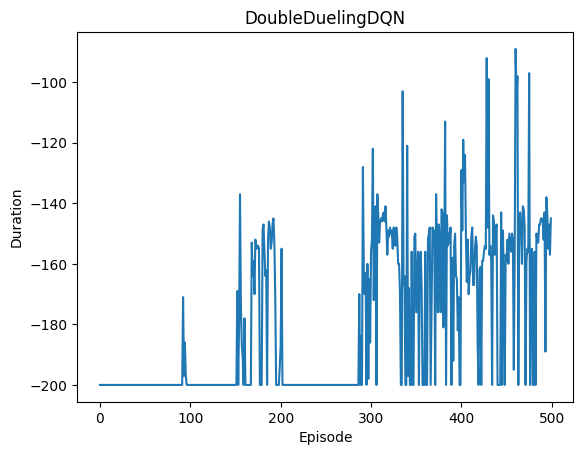

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:

import gymnasium as gym
import numpy as np
from tqdm import tqdm
import pickle

def train():
    env = gym.make("MountainCar-v0")
    n_episodes = 500
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

    agent = DoubleDuelingDQN(env.observation_space.shape[0], env.action_space.n)

    with tqdm(range(0, n_episodes)) as pbar:
        best_reward = -200
        best_ep = 0
        for ep_count in pbar:
            obs, _ = env.reset()
            done = False

            total_reward = 0
            losslist = []
            while not done:
                action = agent.get_action(obs)
                next_obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                agent.store_transition(obs, action, reward, next_obs, done)
                
                if agent.ready_for_train():
                    loss = agent.update_model()
                    losslist.append(loss)

                obs = next_obs
                total_reward += reward
            
            avg_loss = np.mean(np.array(losslist))
            agent.losslist.append(avg_loss)
            agent.episode_durations.append(total_reward)
            
            if total_reward > best_reward:
                best_reward = total_reward
                best_ep = ep_count
            pbar.set_postfix(
                {
                    "reward": total_reward,
                    "best_reward": best_reward,
                    "best_ep" : best_ep,
                    "epsilon": agent.epsilon,
                    "avg_loss": avg_loss
                }
            )
    agent.plot_durations(show_result=True, title=agent.__class__.__name__)
    plt.ioff()
    plt.show()
                
if __name__ == "__main__":
    train()